# Simple atmospheric Emulator

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/02/07
- last update : 2023/02/08


In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import RegularGridInterpolator
import pickle
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [30]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class SimpleAtmEmulator:
    def __init__(self,path='../data/simplegrid'):
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)
            
            
    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ np.array([the_wl,am])   for the_wl in wl]
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ np.array([the_wl,am])   for the_wl in wl]
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ np.array([the_wl,am,pwv])   for the_wl in wl]
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ np.array([the_wl,am,oz])   for the_wl in wl]
        return self.func_OZabs_train(pts)
    
    def GetAllTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):

        if flagRayleigh:
            pts = [ np.array([the_wl,am]) for the_wl in wl]
            transm = self.func_rayleigh_train(pts)
        else:
            transm = np.ones(len(wl))
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        
            
        return transm
            
            
            


In [4]:
AIRMASSMIN=1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [5]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [6]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

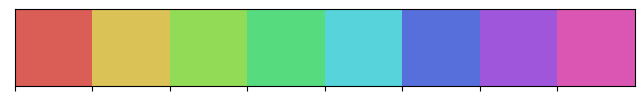

In [7]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

In [8]:
emul = SimpleAtmEmulator()

emul.WL

In [9]:
WL = emul.GetWL()

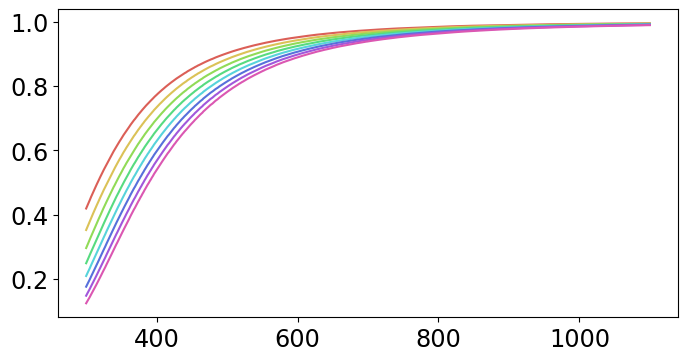

In [10]:
for idx,am in enumerate(airmasses):

    transm = emul.GetRayleighTransparencyArray(WL,am)
    plt.plot(WL,transm,color=hls_colors[idx])

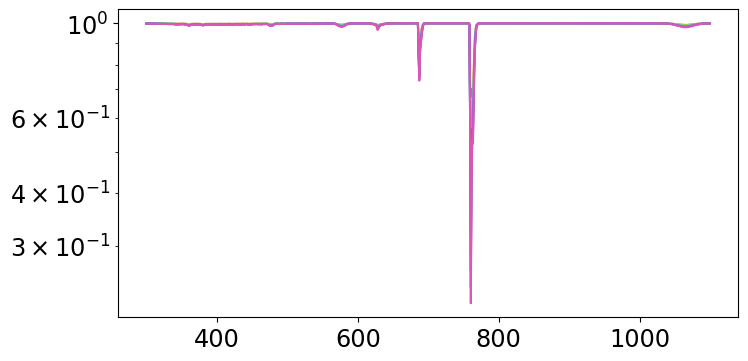

In [11]:
for idx,am in enumerate(airmasses):

    transm = emul.GetO2absTransparencyArray(WL,am)
    plt.plot(WL,transm,color=hls_colors[idx])
plt.yscale('log')

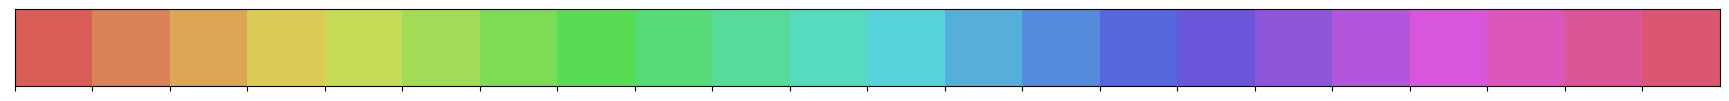

In [12]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

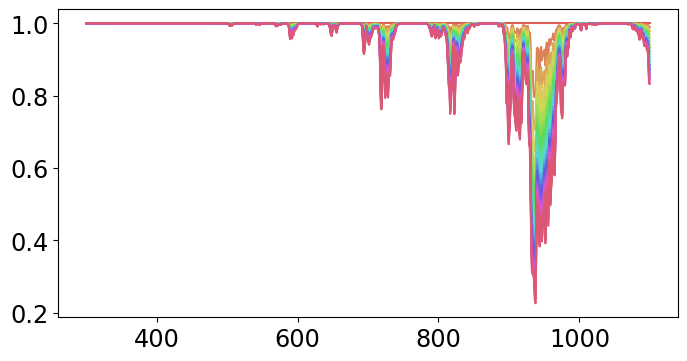

In [13]:
for idx,pwv in enumerate(pwvs):

    transm = emul.GetPWVabsTransparencyArray(WL,am,pwv)
    plt.plot(WL,transm,color=hls_colors[idx])

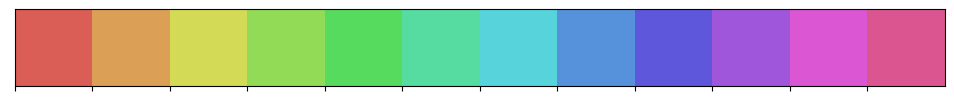

In [14]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

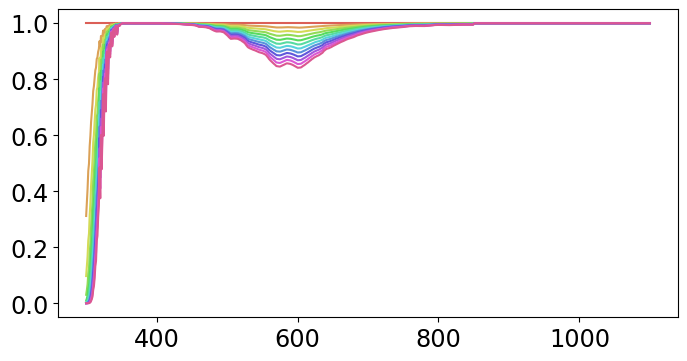

In [15]:
for idx,oz in enumerate(ozs):

    transm = emul.GetOZabsTransparencyArray(WL,am,oz)
    plt.plot(WL,transm,color=hls_colors[idx])

In [35]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.

transm1 = emul.GetAllTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)
path,thefile = libsimulateVisible.ProcessSimulation(am0,pwv0,oz0,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
data1 = np.loadtxt(os.path.join(path,thefile))

am1 = 2.0
pwv1 = 5.0
oz1 = 500.

transm2 = emul.GetAllTransparencies(WL,am1,pwv1,oz1,flagRayleigh=True)
path,thefile = libsimulateVisible.ProcessSimulation(am1,pwv1,oz1,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
data2 = np.loadtxt(os.path.join(path,thefile))

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

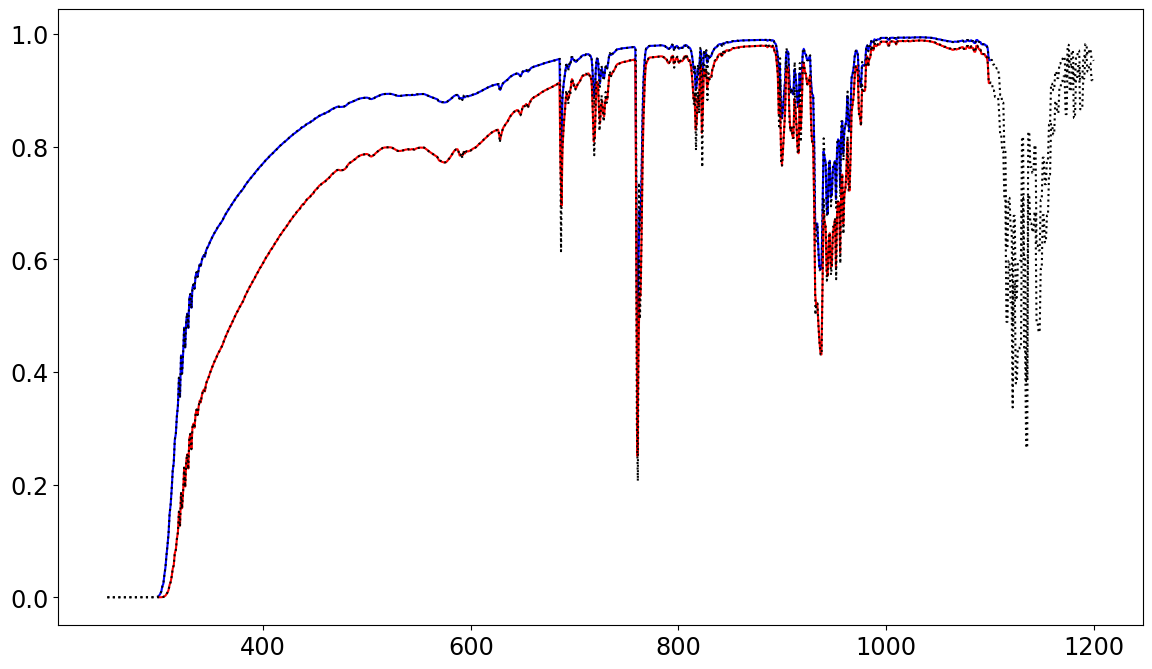

In [38]:
plt.figure(figsize=(14,8))
plt.plot(WL,transm1,'b-')
plt.plot(data1[:,0],data1[:,1],'k:')
plt.plot(WL,transm2,'r-')
plt.plot(data2[:,0],data2[:,1],'k:')